In [1]:
import pystan
import numpy as np
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
import edward as ed

In [2]:
%matplotlib inline

In [3]:
model_code = """
data {
  int N; //the number of observations
  int N2; //the size of the new_X matrix
  int K; //the number of columns in the model matrix
  vector[N] y; //the response
  matrix[N,K] X; //the model matrix
  matrix[N2,K] new_X; //the matrix for the predicted values
}
parameters {
  vector[K] beta; //the regression parameters
  real sigma; //the standard deviation
}
transformed parameters {
  vector[N] linpred;
  linpred = X*beta;
}
model {  
  beta[1] ~ cauchy(0,10); //prior for the intercept following Gelman 2008

  for(i in 2:K)
   beta[i] ~ cauchy(0,2.5);//prior for the slopes following Gelman 2008
  
  y ~ normal(linpred,sigma);
}
generated quantities {
  vector[N2] y_pred;
  y_pred = new_X*beta; //the y values predicted by the model
}
"""

In [4]:
model_name = 'linear_regression'
pkl_file = model_name + '.pkl'

if os.path.isfile(pkl_file):
    # Reuse previously compiled model
    sm = pickle.load(open(pkl_file, 'rb'))
else:
    # Compile and sample model
    sm = pystan.StanModel(model_code=model_code, model_name=model_name)
    with open(pkl_file, 'wb') as f:
        pickle.dump(sm, f)

In [5]:
# Test data
N = 20
beta = np.array([0.2, 1.5]).reshape((-1,1))
x = np.linspace(0, 1, N).reshape((-1, 1))
X = np.column_stack([np.ones(x.shape), x])
y = X.dot(beta) + np.random.normal(0, 0.1, size=N).reshape((-1, 1))

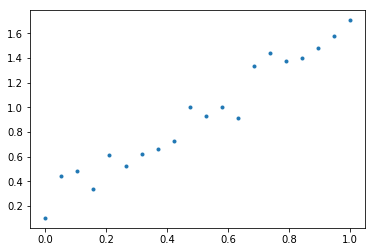

In [6]:
plt.plot(x, y, marker='.', linestyle='none')

In [7]:
# Plot fit
N2 = 2
new_x =  np.linspace(0, 1, N2).reshape((-1, 1))
new_X = np.column_stack([np.ones(N2).reshape((-1, 1)), new_x])

In [8]:
data = {
    'N': N,
    'X': X,
    'K': X.shape[1],
    'y': y.flatten(), 
    'N2': N2,
    'new_X': new_X
}

In [9]:
res = sm.optimizing(data=data)

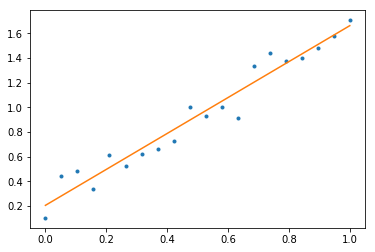

In [10]:
# Plot MLE fit
plt.plot(x, y, marker='.', linestyle='none')
plt.plot(new_x, res['y_pred'])
plt.show()

In [11]:
res_vb = sm.vb(data=data, pars=['beta', 'y_pred'])
out_file = res_vb['args']['sample_file']
df = pd.read_csv(out_file, comment='#').iloc[2:, :]

In [12]:
df.describe()

,lp__,beta.1,beta.2,sigma,linpred.1,linpred.2,linpred.3,linpred.4,linpred.5,linpred.6,...,linpred.13,linpred.14,linpred.15,linpred.16,linpred.17,linpred.18,linpred.19,linpred.20,y_pred.1,y_pred.2
count,999.0,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,...,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000
mean,0.0,0.215291,1.461276,0.132886,0.215291,0.292201,0.369110,0.446019,0.522928,0.599837,...,1.138202,1.215111,1.292021,1.368930,1.445839,1.522748,1.599658,1.676567,0.215291,1.676567
std,0.0,0.027397,0.048795,0.019738,0.027397,0.027564,0.027967,0.028596,0.029436,0.030470,...,0.041609,0.043575,0.045601,0.047679,0.049803,0.051967,0.054166,0.056397,0.027397,0.056397
min,0.0,0.127658,1.295960,0.073348,0.127658,0.201948,0.276237,0.350527,0.424816,0.499106,...,1.005730,1.075490,1.145260,1.215020,1.284790,1.354550,1.423720,1.491930,0.127658,1.491930
25%,0.0,0.197325,1.429195,0.120601,0.197325,0.273546,0.350438,0.426480,0.503127,0.578657,...,1.110900,1.186570,1.261845,1.336625,1.411840,1.487080,1.562545,1.638170,0.197325,1.638170
50%,0.0,0.214628,1.461450,0.132588,0.214628,0.290899,0.368302,0.445737,0.522210,0.599447,...,1.139070,1.216050,1.293520,1.370620,1.446900,1.523900,1.600490,1.676320,0.214628,1.676320
75%,0.0,0.233849,1.493395,0.145927,0.233849,0.311272,0.388263,0.464792,0.542152,0.619298,...,1.164720,1.243235,1.320460,1.399150,1.477130,1.554500,1.633110,1.711105,0.233849,1.711105
max,0.0,0.322182,1.603510,0.197052,0.322182,0.400326,0.478470,0.556614,0.634758,0.712903,...,1.269890,1.353300,1.437090,1.521480,1.605880,1.690270,1.774670,1.859060,0.322182,1.859060


In [13]:
df.head()

,lp__,beta.1,beta.2,sigma,linpred.1,linpred.2,linpred.3,linpred.4,linpred.5,linpred.6,...,linpred.13,linpred.14,linpred.15,linpred.16,linpred.17,linpred.18,linpred.19,linpred.20,y_pred.1,y_pred.2
2,0,0.221595,1.47993,0.140080,0.221595,0.299486,0.377377,0.455268,0.533160,0.611051,...,1.15629,1.23418,1.31207,1.38996,1.46785,1.54574,1.62363,1.70153,0.221595,1.70153
3,0,0.213867,1.44866,0.150075,0.213867,0.290112,0.366357,0.442602,0.518847,0.595092,...,1.12881,1.20505,1.28130,1.35754,1.43379,1.51003,1.58628,1.66252,0.213867,1.66252
4,0,0.171972,1.43864,0.121414,0.171972,0.247690,0.323408,0.399126,0.474844,0.550562,...,1.08059,1.15631,1.23202,1.30774,1.38346,1.45918,1.53490,1.61061,0.171972,1.61061
5,0,0.247125,1.42424,0.111614,0.247125,0.322085,0.397045,0.472005,0.546965,0.621925,...,1.14664,1.22160,1.29656,1.37152,1.44648,1.52144,1.59640,1.67136,0.247125,1.67136
6,0,0.187640,1.40263,0.146581,0.187640,0.261463,0.335285,0.409108,0.482931,0.556754,...,1.07351,1.14734,1.22116,1.29498,1.36881,1.44263,1.51645,1.59027,0.187640,1.59027


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0f9e9a54d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f0f9e8b6210>]], dtype=object)

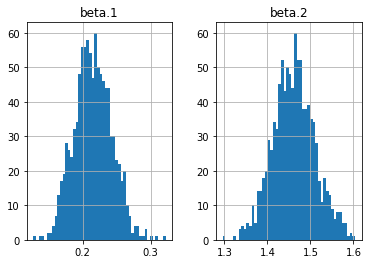

In [14]:
df[['beta.1', 'beta.2']].hist(bins=50)

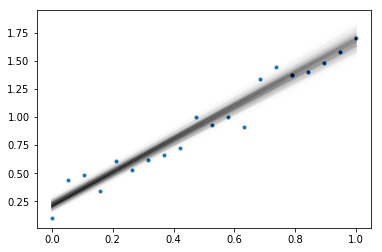

In [15]:
# Plot with generated values after Variational Bayes fit
plt.plot(x, y, marker='.', linestyle='none')
plt.plot(np.tile(new_x, (1, len(df))), df[['y_pred.1', 'y_pred.2']].T.values, alpha=0.005, c='k')
plt.show()

# Edward
Try to replicate Bayesian linear regression using Edward - see http://edwardlib.org/tutorials/supervised-regression

In [16]:
Beta_ed = ed.models.Normal(loc=tf.zeros([2, 1]), scale=tf.ones([2, 1]))
X_ed = X.astype(np.float32)
y_ed = ed.models.Normal(loc=tf.matmul(X_ed, Beta_ed), scale=0.1)

In [17]:
# Different prior - doesn't seem to be a Cauchy distribution in Edward
qBeta = ed.models.Normal(
    loc=tf.Variable(tf.zeros([2, 1])), 
    scale=tf.nn.softplus(tf.Variable(tf.zeros([2, 1]))))

In [18]:
inference = ed.KLqp({Beta_ed: qBeta}, data={y_ed: y})

In [19]:
inference.run(n_samples=5, n_iter=10000)

10000/10000 [100%] ██████████████████████████████ Elapsed: 12s | Loss: -9.780


In [28]:
n_sample = 1000
df_ed = pd.DataFrame(qBeta.sample(n_sample).eval().reshape((n_sample, -1)), columns=['beta.1', 'beta.2'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0f9948c150>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f0f992ed2d0>]], dtype=object)

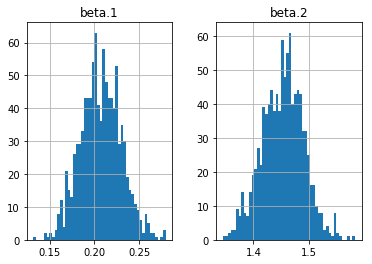

In [30]:
df_ed[['beta.1', 'beta.2']].hist(bins=50)